In [1]:
import numpy as np
import sklearn as sk
import seaborn as sns
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os
current_dir = os.getcwd()

In [2]:
from sklearn.datasets import fetch_california_housing

In [3]:
housing = fetch_california_housing()
m, n = housing.data.shape

In [4]:
frame = pd.DataFrame(housing.data)
frame.head()

,0,1,2,3,4,5,6,7
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [5]:
frame.shape

(20640, 8)

In [6]:
target = pd.DataFrame(housing.target)
target.shape

(20640, 1)

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(frame, target, test_size = 0.20, random_state = 42)

# Ensemble learning


In [8]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor()
gbrt.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
pred = gbrt.predict(x_test)
from sklearn.metrics import mean_squared_error
print('Training score: ', gbrt.score(x_train, y_train))
print('Testing score: ', mean_squared_error(y_test, pred))

Training score:  0.8048978817773167
Testing score:  0.29393470011606526


In [10]:
9000/18000

0.5

In [11]:
np.round(0.51)

1.0

In [12]:
def compute_accuracy(y_test, pred):
    output = []
    for i, j in zip(y_test, pred):
        cal = i/j
        if cal > 1:
            output.append(np.round(j/i))
            
        else:
            output.append(np.round(cal))
            
    return np.sum(output)/len(output)

print(compute_accuracy(y_test, pred))

0.0


In [13]:
x_train.shape

(16512, 8)

# Manually computing MSE with the use of optimizers

In [126]:
from keras.backend import clear_session
# Before instantiating a tf.data.Dataset obj & before model creation, call:
clear_session()

Using TensorFlow backend.


In [127]:
#X = tf.constant(housing_data_plus_bias, dtype =tf.float32, name = 'X')
#y = tf.constant(housing.target.reshape(-1,1), dtype = tf.float32, name = 'y')
#XT = tf.transpose(X)
#theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

#with tf.Session() as sess:
#    theta_value = theta.eval()

In [16]:
batch_size = 1000
n_batches = int(np.ceil(16512/batch_size))
print('number of batches is: ', str(n_batches))

number of batches is:  17


In [17]:
def fetch_batch(batch_index):
    if batch_index < n_batches-1:
        start = batch_index * batch_size
        stop = batch_size + start
        x_batch = x_train[start:stop]
        y_batch = y_train[start:stop]
        
    else:
        start = batch_index* batch_size
        x_batch = x_train[start:]
        y_batch = y_train[start:]
    return x_batch, y_batch

In [18]:
x_train.shape, y_train.shape

((16512, 8), (16512, 1))

In [19]:
m, n = x_train.shape

In [20]:
#X = tf.constant(housing_data_plus_bias, dtype =tf.float32, name = 'X')
#y = tf.constant(housing.target.reshape(-1,1), dtype = tf.float32, name = 'y')

X = tf.placeholder(tf.float32, shape = (None,8), name = 'x')
y = tf.placeholder(tf.float32, shape = (None,1), name = 'y')

with tf.name_scope('loss'):
    #theta = tf.Variable(tf.random_uniform((8,1), -1.0, 1.0), name = 'theta')
    stddev = 2/np.sqrt(8)
    w = tf.Variable(tf.random_normal((8,1), stddev = stddev, name = 'weights'))
    b = tf.Variable(tf.zeros(m,1), name = 'biases')
    y_pred = tf.add(tf.matmul(X,w),b, name= 'predictions')
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name = 'mse')
    
with tf.name_scope('training'):
    learning_rate = 0.01
    optimizer= tf.train.RMSPropOptimizer(learning_rate = learning_rate)
    training_op = optimizer.minimize(mse)
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

train_loss, test_loss = [],[]

n_epochs = 10
with tf.Session() as sess:
    
    init.run()
    for epoch in range(n_epochs):
        batch_step = 0
        avg_loss = 0
        total_loss = 0
        total_batch = int(x_train.shape[0]/batch_size)
        for batch_index in range(n_batches):
            x_batch, y_batch = fetch_batch(batch_index)
            _,l = sess.run([training_op, mse], feed_dict= {X:x_batch, y:y_batch})
            batch_step+=1
            total_loss +=l
        if epoch % 10 == 0: # print 5 batches of epochs
            avg_loss = total_loss/batch_size
            print("Epoch:", '%02d' % (epoch+1), "| Average Training Loss= {:.2f}".format(avg_loss), 
                  "| Training Accuracy:  {:.2f}".format(mse.eval({X: x_train, y: y_train})),
                  "| Test/Validation Accuracy:  {:.2f}".format(mse.eval({X: x_test, y: y_test})))
            train_loss.append(mse.eval({X:x_train, y:y_train}))
            test_loss.append(mse.eval({X:x_test, y:y_test}))
        else:
            train_loss.append(mse.eval({X:x_train, y:y_train}))
            test_loss.append(mse.eval({X:x_test, y:y_test}))
    
    print("Model fit complete.")
    print("Final Training MSE: {:.2f}".format(mse.eval({X: x_train, y: y_train})))
    print("Final Validation MSE: {:.2f}".format(mse.eval({X: x_test, y: y_test})))
    save_path = saver.save(sess, './house_reg.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch: 01 | Average Training Loss= 13934.86 | Training Accuracy:  487066.78 | Test/Validation Accuracy:  476669.84
Model fit complete.
Final Training MSE: 139.37
Final Validation MSE: 102.96


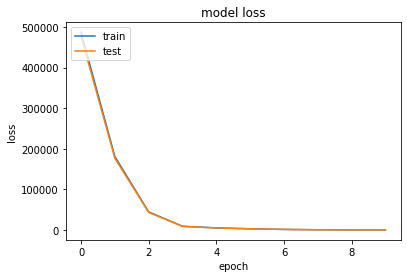

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


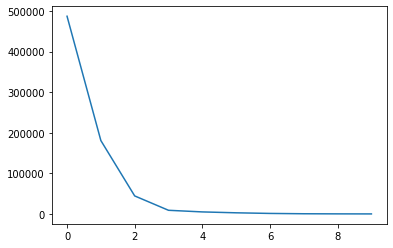

In [22]:
epoch_list = [i for i in range(10)]
import seaborn as sns
ax = sns.lineplot(x=epoch_list, y=train_loss)

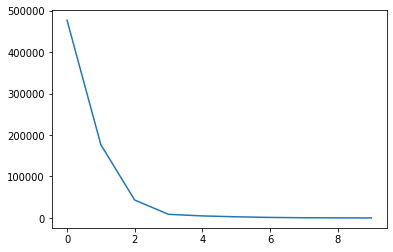

In [23]:
epoch_list = [i for i in range(10)]
import seaborn as sns
ax = sns.lineplot(x=epoch_list, y=test_loss)

# Neural Networks

In [128]:
from keras.backend import clear_session
# Before instantiating a tf.data.Dataset obj & before model creation, call:
clear_session()

In [129]:
n_inputs = 8
h1 = 40
h2 = 100
h3 = 20
n_output = 1

X = tf.placeholder(tf.float32, shape = (None,8), name = 'x')
y = tf.placeholder(tf.float32, shape = (None,1), name = 'y')


def neuron_layer(X, n_neurons, name, activation = None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2/ np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev = stddev)
        W = tf.Variable(init, name = 'weights')
        b = tf.Variable(tf.zeros([n_neurons]), name = 'biases')
        z = tf.matmul(X, W) + b
        
        if activation == 'relu':
            return tf.nn.relu(z)
        
        else:
            return z
        
with tf.name_scope('NeuralNet'):
    hidden1 = neuron_layer(X, h1, 'hidden1', activation = 'relu')
    hidden2 = neuron_layer(hidden1, h2, 'hidden2', activation = 'relu')
    hidden3 = neuron_layer(hidden2, h3, 'hidden3', activation = 'relu')
    y_pred = neuron_layer(hidden3, n_output, 'outputs')

    
with tf.name_scope('loss'):
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name = 'mse')
    
  

In [130]:
with tf.name_scope('training'):
    learning_rate = 0.01
    optimizer = tf.train.RMSPropOptimizer(learning_rate = learning_rate)
    training_op = optimizer.minimize(mse)
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

train_loss = []
test_loss = []
n_epochs = 10


with tf.Session() as sess:
    writer = tf.summary.FileWriter('logs', sess.graph)
    init.run()
    for epoch in range(n_epochs):
        batch_step = 0
        avg_loss = 0
        total_loss = 0
        total_batch = int(x_train.shape[0]/batch_size)
        for batch_index in range(n_batches):
            x_batch, y_batch = fetch_batch(batch_index)
            _,l = sess.run([training_op, mse], feed_dict= {X:x_batch, y:y_batch})
            batch_step+=1
            total_loss +=l
        if epoch % 10 == 0: # print 5 batches of epochs
            avg_loss = total_loss/batch_size
            print("Epoch:", '%02d' % (epoch+1), "| Average Training Loss= {:.2f}".format(avg_loss), 
                  "| Training Accuracy:  {:.2f}".format(mse.eval({X: x_train, y: y_train})),
                  "| Test/Validation Accuracy:  {:.2f}".format(mse.eval({X: x_test, y: y_test})))
            train_loss.append(mse.eval({X:x_train, y:y_train}))
            test_loss.append(mse.eval({X:x_test, y:y_test}))
        
        else:
            train_loss.append(mse.eval({X:x_train, y:y_train}))
            test_loss.append(mse.eval({X:x_test, y:y_test}))
                
         
    
    print("Model fit complete.")
    print("Final Training MSE: {:.2f}".format(mse.eval({X: x_train, y: y_train})))
    print("Final Validation MSE: {:.2f}".format(mse.eval({X: x_test, y: y_test})))
    save_path = saver.save(sess, './house_reg2.h5')
    writer.close()

Epoch: 01 | Average Training Loss= 108980.76 | Training Accuracy:  19065.12 | Test/Validation Accuracy:  18829.13
Model fit complete.
Final Training MSE: 2.32
Final Validation MSE: 2.28


In [131]:
import datetime, os
import tensorboard
%load_ext tensorboard

#%reload_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir} --host localhost --port 8008

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8008 (pid 18659), started 0:15:37 ago. (Use '!kill 18659' to kill it.)

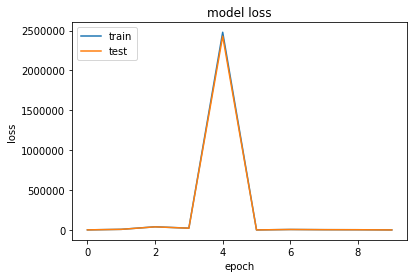

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


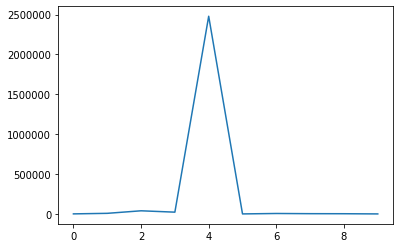

In [107]:
epoch_list = [i for i in range(10)]
import seaborn as sns
ax = sns.lineplot(x=epoch_list, y=train_loss)

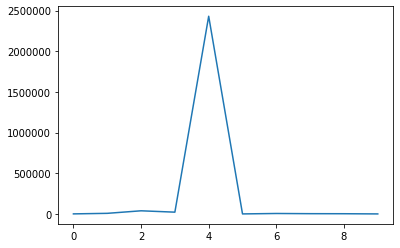

In [108]:
epoch_list = [i for i in range(n_epochs)]
import seaborn as sns
ax = sns.lineplot(x=epoch_list, y=test_loss)

# Keras in tensorflow

In [133]:
from tensorflow.compat.v1.keras.backend import clear_session
# Before instantiating a tf.data.Dataset obj & before model creation, call:
clear_session()

In [134]:
from tensorflow.keras import layers
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model = tf.keras.Sequential()
model.add(layers.Dense(40,input_shape=(8,), activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1))


In [135]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.01),
              loss= tf.keras.losses.mean_squared_error,
              metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                360       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 6,501
Trainable params: 6,501
Non-trainable params: 0
_________________________________________________________________


In [136]:
h = model.fit(x_train, y_train, epochs=10, batch_size=1000,validation_data=(x_test, y_test),callbacks=[tensorboard_callback])

Train on 16512 samples, validate on 4128 samples
Epoch 1/10
16512/16512 [==============================] - 0s 13us/sample - loss: 19888.0934 - mse: 19888.0938 - val_loss: 9.3827 - val_mse: 9.3827
Epoch 2/10
16512/16512 [==============================] - 0s 5us/sample - loss: 943.2260 - mse: 943.2261 - val_loss: 33.9062 - val_mse: 33.9062
Epoch 3/10
16512/16512 [==============================] - 0s 5us/sample - loss: 505.2381 - mse: 505.2382 - val_loss: 23.5241 - val_mse: 23.5241
Epoch 4/10
16512/16512 [==============================] - 0s 5us/sample - loss: 6.1131 - mse: 6.1131 - val_loss: 11.3553 - val_mse: 11.3553
Epoch 5/10
16512/16512 [==============================] - 0s 5us/sample - loss: 14.0595 - mse: 14.0595 - val_loss: 8.7876 - val_mse: 8.7876
Epoch 6/10
16512/16512 [==============================] - 0s 5us/sample - loss: 6.5747 - mse: 6.5747 - val_loss: 2.3680 - val_mse: 2.3680
Epoch 7/10
16512/16512 [==============================] - 0s 5us/sample - loss: 1.8906 - mse: 1.89

In [137]:
%tensorboard --logdir logs/scalars

Reusing TensorBoard on port 6011 (pid 18837), started 0:07:35 ago. (Use '!kill 18837' to kill it.)

In [118]:
with tf.Session() as sess:
    init.run()
    dict_h = h.history

In [119]:
dict_h.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

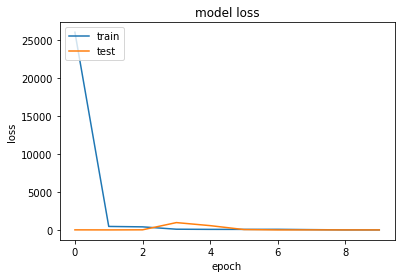

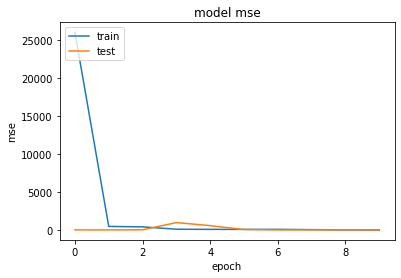

In [120]:
# summarize history for accuracy

plt.plot(dict_h['loss'])
plt.plot(dict_h['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(dict_h['mse'])
plt.plot(dict_h['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [121]:
model.evaluate(x_test, y_test)

4128/4128 [==============================] - 0s 27us/sample - loss: 1.6663 - mse: 1.6663


[1.666309392729471, 1.6663095]

In [122]:
model.evaluate(x_train, y_train)

16512/16512 [==============================] - 0s 29us/sample - loss: 1.7238 - mse: 1.7238


[1.7238131475078968, 1.7238128]